## Introduction

### In this notebook we use [Context-Conditional GAN (CCGAN)](https://arxiv.org/abs/1604.07379) to perform Image Inpainting on [CelebA dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html).

<h4><center>Semantic Inpainting results on held-out images by Context Encoder.</center></h4>
<img src="http://people.eecs.berkeley.edu/~pathak/context_encoder/resources/result_fig.jpg" width="900" height="900"/>
<h4></h4>
<h4><center>Image Source:  <a href="https://arxiv.org/abs/1609.04802">Context Encoders: Feature Learning by Inpainting [Deepak Pathak et al.]</a></center></h4>

### Libraries 📚⬇

In [39]:
# Originally from a different project https://www.kaggle.com/code/balraj98/context-encoder-gan-for-image-inpainting-pytorch/notebook but modified
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid

import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

random.seed(42)
import warnings
warnings.filterwarnings("ignore")

### Settings ⚙️

In [40]:
# load pretrained models
load_pretrained_models = False
# number of epochs of training
n_epochs = 30
# size of the batches
batch_size = 10
# name of the dataset
dataset_name = "../Data/img_align_celeba"
dataset_name = "../Data/genre_original/disco"
# adam: learning rate
# lr = 0.00008
lr = 0.00008


def lr_decay(global_step,
    init_learning_rate = .0625,
    min_learning_rate = .008,
    decay_rate = 0.5):
    lr = ((init_learning_rate - min_learning_rate) *
          pow(decay_rate, global_step) +
          min_learning_rate)
    return lr

lr0 = lr_decay(0)




# adam: decay of first order momentum of gradient
b1 = 0.5
# adam: decay of first order momentum of gradient
b2 = 0.999
# number of cpu threads to use during batch generation
n_cpu = 4
# dimensionality of the latent space
latent_dim = 100
# size of each image dimension
img_size = 130560
# size of random mask
mask_size = 12500

mask_array_hieght = 1024
mask_array_width = 25
# number of image channels
channels = 3
# interval between image sampling
sample_interval = 10

cuda = True if torch.cuda.is_available() else False
os.makedirs("images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

# Calculate output dims of image discriminator (PatchGAN)
patch_h, patch_w = int(mask_array_hieght / 2 ** 3), int(mask_array_width / 4 ** 3)
#needed to adjust for the tiny width 24 for patch and 64 for whole
patch_w = 24
patch = (1, patch_h, patch_w)

print(patch)

(1, 128, 24)


### STFT Experiment

stft: [[ 4.60542664e-02+0.0000000e+00j -4.43770617e-01+0.0000000e+00j
  -5.99667311e-01+0.0000000e+00j ... -3.60285223e-01+0.0000000e+00j
  -6.31443322e-01+0.0000000e+00j -3.85448486e-01+0.0000000e+00j]
 [-1.46420762e-01-5.6706911e-01j  3.34686935e-01+1.6043675e-01j
   6.35136843e-01-4.1177714e-01j ... -3.62014472e-02-5.0451890e-02j
   6.01221681e-01-2.0406917e-01j  7.97729194e-03+4.3300587e-01j]
 [ 5.78518987e-01+1.0901452e+00j -7.34995827e-02-8.3045483e-01j
   1.93367183e-01+1.0642042e+00j ...  2.49943033e-01-6.8545431e-01j
  -1.05798268e+00+4.9893191e-01j  5.36575496e-01+6.5025464e-02j]
 ...
 [ 2.71459017e-03-1.9027159e-04j -1.57325680e-03+1.7014075e-04j
   3.58845078e-04-3.5436373e-05j ... -1.69312358e-02+8.1507191e-03j
   2.73987763e-02-1.3132452e-02j -1.08408816e-02+5.1597315e-03j]
 [-2.48493184e-03+2.4046829e-04j  3.45612381e-04+1.1170162e-03j
  -1.36391856e-04-2.6543237e-05j ... -4.25701914e-03-1.8307278e-02j
  -2.97020469e-02+6.7816423e-03j  2.64718803e-03+1.1712914e-02j]
 [ 2

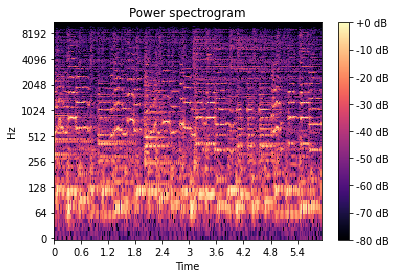

In [41]:
import librosa
import soundfile as sf
from librosa import display
import numpy as np
import torch 
import torchvision 
import torchvision.transforms as T 
from PIL import Image 
import matplotlib.pyplot as plt
import torchaudio

sample_path = '../Data/genres_original/jazz/jazz.00005.wav'
# sample_path = 'testStuff/20.wav'
y, sr = librosa.load(sample_path)
# for x in range(15000, 45000):
#     y[x] = 0
D = librosa.stft(y)
y_hat = librosa.istft(D)
# print(f'istft: {y_hat}')
# print(f'sr: {sr}')


# NEW LENGTH GOAL 131129

musicLen = 131000
y = y[:musicLen]
n_fft = 2048
y_pad = librosa.util.fix_length(y, size=musicLen + n_fft // 2)
D = librosa.stft(y_pad, n_fft=n_fft)
y_out = librosa.istft(D, length=musicLen)
adjustedN = math.ceil(23000/661794)
print(f'stft: {D}')
print(f'stft: {D.shape}')
print(f'istft size: {y_out.size}')
print(f'max: {np.min(np.abs(y_out))}')
masked_part = y_out.copy()[15000:27500]
d = librosa.stft(masked_part, n_fft=n_fft)
print(f'XXXXXXXXXXX d : {d.shape}')
print(d.shape)
d_out = librosa.istft(d, length=12500)
print(f'd_out size = {len(d_out)}')

transform = T.Resize(size = (512,512))
# for x in range(15000, 27500):
#     y_out[x] = 0


# print(f'D: {D.shape}')
# D = transform(D)
# print(f'D: {D.shape}')
# transform2 = T.Resize(size=(1025, 1295))
# D = transform2(D)

# y_out = librosa.istft(D, length=n)
# print(f'D: {D.shape}')

# y_out[15000: 27500] = d_out
# d_out = d_out[:musicLen*adjustedN]

D = librosa.stft(y_out, n_fft=n_fft)
D = torch.FloatTensor([librosa.stft(y_out, n_fft=n_fft)])
originalShape = D.shape
D = D[0].numpy()

sf.write('../Data/genres_original/bluesTest/blues.00000.wav', y_out, sr)

S = np.abs(D)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
img = display.specshow(librosa.amplitude_to_db(S,
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")




### Define Dataset Class

In [42]:
# class ImageDataset(Dataset):
#     def __init__(self, root, transforms_=None, img_size=128, mask_size=64, mode="train"):
#         self.transform = transforms.Compose(transforms_)
#         self.img_size = img_size
#         self.mask_size = mask_size
#         self.mode = mode
#         self.files = sorted(glob.glob("%s/*.jpg" % root))
#         # self.files = self.files[:-4000] if mode == "train" else self.files[-4000:]

#     def apply_random_mask(self, img):
#         """Randomly masks image"""
#         y1, x1 = np.random.randint(0, self.img_size - self.mask_size, 2)
#         y2, x2 = y1 + self.mask_size, x1 + self.mask_size
#         masked_part = img[:, y1:y2, x1:x2]
#         masked_img = img.clone()
#         masked_img[:, y1:y2, x1:x2] = 1

#         return masked_img, masked_part, (y1, x1)

#     def apply_center_mask(self, img):
#         """Mask center part of image"""
#         # Get upper-left pixel coordinate
#         i = (self.img_size - self.mask_size) // 2
#         masked_img = img.clone()
#         masked_img[:, i : i + self.mask_size, i : i + self.mask_size] = 1

#         return masked_img, i

#     def apply_random_line_mask(self, img):
#         """Randomly masks image"""
#         y1, x1 = np.random.randint(0, self.img_size - self.mask_size, 2)
#         y2, x2 = y1 + self.mask_size, x1 + self.mask_size
#         masked_part = img[:, y1:y2, x1:x2]
#         masked_img = img.clone()
#         masked_img[:, y1:y2, x1:x2] = 1

#         return masked_img, masked_part

#     def apply_center_line_mask(self, img):
#         """Mask center part of image"""
#         # Get upper-left pixel coordinate
#         i = (self.img_size - self.mask_size) // 2
#         masked_img = img.clone()
#         masked_img[:, i : i + self.mask_size, i : i + self.mask_size] = 1

#         return masked_img, i
    

#     def __getitem__(self, index):
#         img = Image.open(self.files[index]).convert('RGB')
#         img = self.transform(img)
#         if self.mode == "train":
#             # For training data perform random mask
#             masked_img, aux, i = self.apply_random_mask(img)
#         else:
#             # For test data mask the center of the image
#             masked_img, aux = self.apply_center_mask(img)
#             i = aux

#         return img, masked_img, aux, i

#     def __len__(self):
#         return len(self.files)

In [43]:
# Originally from other project but heavily modified
class AudioDataset(Dataset):
    def __init__(self, root, transforms_=None, img_size=131000, mask_size=12500, mode="train"):
        self.transform = transforms.Compose(transforms_)
        self.img_size = img_size
        self.mask_size = mask_size
        self.mode = mode
        self.files = sorted(glob.glob("%s/*" % root))
        self.transform2 = T.Resize(size=(1024, 256))
        self.transform1 = T.Resize(size=(1024, 25))

        # self.files = self.files[:-4000] if mode == "train" else self.files[-4000:]

    def apply_random_mask(self, img):
        """Randomly masks image"""
        y1 = np.random.randint(0, self.img_size - self.mask_size - 500)
        y2 = y1 + self.mask_size
        masked_part = img[y1:y2]
        masked_img = img.copy()
        # print(f'y1 = {y1}')
        # print(f'y2 = {y2}')
        # # print(y2 - y1)
        # print(f'masked image shape from Loader: {masked_img.shape}')
        # print(len(masked_imgs) > self.mask_size)
        masked_img[y1:y2] = [0] * self.mask_size

        return masked_img, masked_part, y1

    def apply_center_mask(self, img):
        """Mask center part of image"""
        # Get upper-left pixel coordinate
        i = (self.img_size - self.mask_size) // 2
        masked_img = img.copy()
        masked_img[i : i + self.mask_size] = [0] * self.mask_size

        return masked_img, i
    

    def __getitem__(self, index):
        y, sr = librosa.load(self.files[index])
        y = y[:img_size]
        # y = self.transform(y)
        if self.mode == "train":
            # For training data perform random mask
            # print(y.shape)
            masked_img, aux, i = self.apply_random_mask(y)
            aux = torch.FloatTensor([librosa.stft(aux, n_fft=n_fft)])
            aux = self.transform1(aux)
        else:
            # For test data mask the center of the image
            masked_img, aux = self.apply_center_mask(y)
            i = aux
        
        masked_img = torch.FloatTensor([librosa.stft(masked_img, n_fft=n_fft)])
        img = torch.FloatTensor([librosa.stft(y, n_fft=n_fft)])
        # masked_img = self.transform2(masked_img)
        # img = self.transform2(img)




        return img, masked_img, aux, i

    def __len__(self):
        return len(self.files)



### Get Train/Test Dataloaders

In [44]:

dataset_name = "../Data/img_align_celeba"
# dataset_name = "../Data/genre_original/jazz"

files = sorted(glob.glob("%s/*" % dataset_name))
print(files)


transforms_ = [
    transforms.Resize((1024, 646), Image.LANCZOS),
    transforms.ToTensor(),
]

print(os.path.isdir(dataset_name))
print(os.path.exists(dataset_name))
print(len(os.listdir(dataset_name)))

dataset = AudioDataset(dataset_name)

print(len(dataset))

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)
test_dataloader = DataLoader(
    AudioDataset(dataset_name, transforms_=transforms_, mode="val", img_size=img_size, mask_size=mask_size),
    batch_size=1,
    shuffle=True,
    num_workers=0,
)

['../Data/img_align_celeba/blues.00000.wav', '../Data/img_align_celeba/blues.00001.wav', '../Data/img_align_celeba/blues.00002.wav', '../Data/img_align_celeba/blues.00003.wav', '../Data/img_align_celeba/blues.00004.wav', '../Data/img_align_celeba/blues.00005.wav', '../Data/img_align_celeba/blues.00006.wav', '../Data/img_align_celeba/blues.00007.wav', '../Data/img_align_celeba/blues.00008.wav', '../Data/img_align_celeba/blues.00009.wav', '../Data/img_align_celeba/blues.00010.wav', '../Data/img_align_celeba/blues.00011.wav', '../Data/img_align_celeba/blues.00012.wav', '../Data/img_align_celeba/blues.00013.wav', '../Data/img_align_celeba/blues.00014.wav', '../Data/img_align_celeba/blues.00015.wav', '../Data/img_align_celeba/blues.00016.wav', '../Data/img_align_celeba/blues.00017.wav', '../Data/img_align_celeba/blues.00018.wav', '../Data/img_align_celeba/blues.00019.wav', '../Data/img_align_celeba/blues.00020.wav', '../Data/img_align_celeba/blues.00021.wav', '../Data/img_align_celeba/blues

<h3><center>Model Architecture</center></h3>
<img src="https://miro.medium.com/max/700/1*fJpamgw0yBZZRNEuex07hw.png" width="1000" height="1000"/>
<h4></h4>
<h4><center>Image Source:  <a href="https://arxiv.org/abs/1609.04802">Context Encoders: Feature Learning by Inpainting [Deepak Pathak et al.]</a></center></h4>

### Define Model Classes for Image

In [45]:
# class Generator(nn.Module):
#     def __init__(self, channels=3):
#         super(Generator, self).__init__()

#         def downsample(in_feat, out_feat, normalize=True):
#             layers = [nn.Conv2d(in_feat, out_feat, 4, stride=2, padding=1)]
#             if normalize:
#                 layers.append(nn.BatchNorm2d(out_feat, 0.8))
#             layers.append(nn.LeakyReLU(0.2))
#             return layers

#         def upsample(in_feat, out_feat, normalize=True):
#             layers = [nn.ConvTranspose2d(in_feat, out_feat, 4, stride=2, padding=1)]
#             if normalize:
#                 layers.append(nn.BatchNorm2d(out_feat, 0.8))
#             layers.append(nn.ReLU())
#             return layers

#         self.model = nn.Sequential(
#             *downsample(channels, 64, normalize=False),
#             *downsample(64, 64),
#             *downsample(64, 128),
#             *downsample(128, 256),
#             *downsample(256, 512),
#             nn.Conv2d(512, 4000, 1),
#             *upsample(4000, 512),
#             *upsample(512, 256),
#             *upsample(256, 128),
#             *upsample(128, 64),
#             nn.Conv2d(64, channels, 3, 1, 1),
#             nn.Tanh(),
#             # nn.MaxPool2d(img_size // 64)
#         )

#     def forward(self, x):
#         return self.model(x)

# # TODO MAKE IT BUILD BACK UP
# class Discriminator(nn.Module):
#     def __init__(self, channels=3):
#         super(Discriminator, self).__init__()

#         def discriminator_block(in_filters, out_filters, stride, normalize):
#             """Returns layers of each discriminator block"""
#             layers = [nn.Conv2d(in_filters, out_filters, 3, stride, 1)]
#             if normalize:
#                 layers.append(nn.InstanceNorm2d(out_filters))
#             layers.append(nn.LeakyReLU(0.2, inplace=True))
#             return layers

#         layers = []
#         in_filters = channels
#         # change this for resizing the input
#         for out_filters, stride, normalize in [ (64, 2, False), (128, 2, False), (256, 2, True), (512, 1, True)]:
#             layers.extend(discriminator_block(in_filters, out_filters, stride, normalize))
#             in_filters = out_filters

#         layers.append(nn.Conv2d(out_filters, 1, 3, 1, 1))

#         self.model = nn.Sequential(*layers)

#     def forward(self, img):
#         return self.model(img)

### Audio Models


In [46]:
# class Generator(nn.Module):
#     def __init__(self, channels=1):
#         super(Generator, self).__init__()

#         def downsample(in_feat, out_feat, normalize=True):
#             layers = [nn.Conv2d(in_feat, out_feat, 4, stride=2, padding=1)]
#             if normalize:
#                 layers.append(nn.BatchNorm2d(out_feat, 0.8))
#             layers.append(nn.LeakyReLU(0.2))
#             return layers

#         def upsample(in_feat, out_feat, normalize=True):
#             layers = [nn.ConvTranspose2d(in_feat, out_feat, 4, stride=(2, 1), padding=1)]
#             if normalize:
#                 layers.append(nn.BatchNorm2d(out_feat, 0.8))
#             layers.append(nn.ReLU())
#             return layers

#         self.model = nn.Sequential(
#             *downsample(channels, 64, normalize=False),
#             *downsample(64, 64),
#             *downsample(64, 128),
#             *downsample(128, 256),
#             *downsample(256, 512),
#             nn.Conv2d(512, 4000, 1),
#             *upsample(4000, 512),
#             *upsample(512, 256),
#             *upsample(256, 128),
#             *upsample(128, 64),
#             *upsample(64, 32),
#             nn.Conv2d(32, channels, 3, 1, 1),
#             # nn.Tanh(),
#             # nn.MaxPool2d(img_size // 64)
#         )

#     def forward(self, x):
#         return self.model(x)


# Originally from other project but slightly modified
# PATCH ONLY

class Discriminator(nn.Module):
    def __init__(self, channels=1):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, stride, normalize):
            """Returns layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 3, stride, 1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = channels
        for out_filters, stride, normalize in [(64, (2,1), False), (128, (2,1), True), (256, (2,1), True), (512, 1, True)]:
            layers.extend(discriminator_block(in_filters, out_filters, stride, normalize))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, 3, 1, 1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)



# # Full picture

# class Discriminator(nn.Module):
#     def __init__(self, channels=1):
#         super(Discriminator, self).__init__()

#         def discriminator_block(in_filters, out_filters, stride, normalize):
#             """Returns layers of each discriminator block"""
#             layers = [nn.Conv2d(in_filters, out_filters, 3, stride, 1)]
#             if normalize:
#                 layers.append(nn.InstanceNorm2d(out_filters))
#             layers.append(nn.LeakyReLU(0.2, inplace=True))
#             return layers

#         layers = []
#         in_filters = channels
#         for out_filters, stride, normalize in [(64, (2,2), False), (128, (2,2), True), (256, (2,2), True), (512, 1, True)]:
#             layers.extend(discriminator_block(in_filters, out_filters, stride, normalize))
#             in_filters = out_filters

#         layers.append(nn.Conv2d(out_filters, 1, 3, 1, 1))

#         self.model = nn.Sequential(*layers)

#     def forward(self, img):
#         return self.model(img)

# my_gen = Generator()







### Simpler Models

In [47]:
# Originally from other project but slightly modified
class Generator(nn.Module):
    def __init__(self, channels=1):
        super(Generator, self).__init__()

        def downsample(in_feat, out_feat, normalize=True):
            layers = [nn.Conv2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2))
            return layers

        def upsample(in_feat, out_feat, normalize=True):
            layers = [nn.ConvTranspose2d(in_feat, out_feat, 4, stride=(2, 1), padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.ReLU())
            return layers

        def upsampleLast(in_feat, out_feat, normalize=True):
            layers = [nn.ConvTranspose2d(in_feat, out_feat, 4, stride=(2, 2), padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.ReLU())
            return layers

        self.model = nn.Sequential(
            *downsample(channels, 64, normalize=False),
            *downsample(64, 64),
            *downsample(64, 128),
            *downsample(128, 256),
            *downsample(256, 512),
            nn.Conv2d(512, 4000, 1),
            *upsample(4000, 512),
            *upsample(512, 256),
            *upsample(256, 128),
            *upsample(128, 64),
            *upsampleLast(64, 32),
            nn.Conv2d(32, channels, 3, 1, 1),
            # nn.Tanh(),
            # nn.MaxPool2d(img_size // 64)
        )

    def forward(self, x):
        return self.model(x)

# # TODO MAKE IT BUILD BACK UP
# class Discriminator(nn.Module):
#     def __init__(self, channels=1):
#         super(Discriminator, self).__init__()

#         def discriminator_block(in_filters, out_filters, stride, normalize):
#             """Returns layers of each discriminator block"""
#             layers = [nn.Conv2d(in_filters, out_filters, 3, stride, 1)]
#             if normalize:
#                 layers.append(nn.InstanceNorm2d(out_filters))
#             layers.append(nn.LeakyReLU(0.2, inplace=True))
#             return layers
#         def upsample(in_feat, out_feat, normalize=True):
#             layers = [nn.ConvTranspose2d(in_feat, out_feat, 4, stride=2, padding=1)]
#             if normalize:
#                 layers.append(nn.BatchNorm2d(out_feat, 0.8))
#             layers.append(nn.ReLU())
#             return layers

#         layers = []
#         in_filters = channels
#         # change this for resizing the input
#         for out_filters, stride, normalize, downsize in [ (64, 2, False, True), (128, 2, False, True), 
#                                                             (256, 2, True, True), (512, 2, True, True), 
#                                                             (256, 2, True, False), (128, 2, False, False),
#                                                             (64, 2, False, False), (32, 2, False, False) ]:
#             if downsize:
#                 layers.extend(discriminator_block(in_filters, out_filters, stride, normalize))
#                 in_filters = out_filters
#             else:
#                 layers.extend(upsample(in_filters, out_filters, normalize))
#                 in_filters = out_filters

#         layers.append(nn.Conv2d(out_filters, 1, 3, 1, 1))

#         self.model = nn.Sequential(*layers)

#     def forward(self, img):
#         return self.model(img)

my_gen = Generator()
my_dis = Discriminator()
x = torch.ones((1, 1, 1024, 24))
y = my_dis(x)
print(y.shape)



torch.Size([1, 1, 128, 24])


### Train Context-Encoder GAN

In [48]:
# Originally from other project but heavily modified

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

def save_sample(batches_done):
    print('batch')
    samples, masked_samples, aux, i = next(iter(test_dataloader))
    samples = Variable(samples.type(Tensor))
    masked_samples = Variable(masked_samples.type(Tensor))
    # print(i)
    # y1, x1 = i[0].item()  # Upper-left coordinate of mask
    # Generate inpainted image
    gen_mask = generator(masked_samples)
    filled_samples = masked_samples.clone()
    filled_samples = audio_package_fake(filled_samples, i, gen_mask, True)
    # filled_samples[:, :, y1 : y1 + mask_size, x1 : x1 + mask_size] = gen_mask
    # Save sample
    # sample = torch.cat((masked_samples.data, filled_samples.data, samples.data), -2)
    # save_image(sample, "testStuff/%d.png" % batches_done, nrow=6, normalize=True)
    sf.write("testStuff/%d.wav" % batches_done, filled_samples, sr)


def save_best_sample(batches_done, masked_samples, gen_mask):
    filled_samples = masked_samples.clone()
    filled_samples = audio_package_fake(filled_samples, i, gen_mask, True)
    sf.write(f"best_pixel_loss/{batches_done}.wav", filled_samples, sr)

def modify_sample(batches_done):
    print('batch')
    samples, masked_samples, aux, i = next(iter(test_dataloader))
    samples = Variable(samples.type(Tensor))
    masked_samples = Variable(masked_samples.type(Tensor))
    # print(i)
    # y1, x1 = i[0].item()  # Upper-left coordinate of mask
    # Generate inpainted image
    gen_mask = generator(masked_samples)
    filled_samples = masked_samples.clone()
    filled_samples = audio_package_fake(filled_samples, i, gen_mask, True)
    # filled_samples[:, :, y1 : y1 + mask_size, x1 : x1 + mask_size] = gen_mask
    # Save sample
    # sample = torch.cat((masked_samples.data, filled_samples.data, samples.data), -2)
    # save_image(sample, "testStuff/%d.png" % batches_done, nrow=6, normalize=True)
    sf.write("modifyStuff/%d.wav" % batches_done, filled_samples, sr)

def audio_referbish(img, i, gen_mask, prep=False):
    transform = T.Resize(size=(1025, 256))
    transform1 = T.Resize(size=(1025, 25))
    transform2 = T.Resize(size=(1024, 256))
    filled_fake = img.clone()
    filled_fake = transform(filled_fake)
    filled_fake = filled_fake[0][0].numpy()
    gen_mask = transform1(gen_mask)
    gen_mask = gen_mask[0][0].detach()

    # gen_mask[:, 1:3] = 0
    gen_mask = gen_mask.numpy()
    # print(f'this is the shape of gen_mask: {gen_mask.shape}')
    d = librosa.istft(gen_mask, length=mask_size)
    # print(f'this is the length of d: {len(d)}')
    y_out = librosa.istft(filled_fake, length=musicLen)
    # print(f'y_out shape: {y_out.shape}' )
    y_out[i:i+mask_size] = d
    if prep:
        return y_out
    filled_fake =  torch.FloatTensor([[librosa.stft(y_out, n_fft=n_fft)]])
    filled_fake = transform2(filled_fake)
    # filled_fake = Variable(filled_fake.type(Tensor))
    return filled_fake

def package_fake(masked_sample, i, gen_mask):
    y1, x1 = i
    filled_fake = masked_sample.clone()
    filled_fake = Variable(filled_fake.type(Tensor))
    filled_fake[:, :, y1 : y1 + mask_size, x1 : x1 + mask_size] = gen_mask
    return filled_fake

def audio_package_fake(img, i, gen_mask, prep=False):
    transform = T.Resize(size=(1025, 256))
    transform1 = T.Resize(size=(1025, 25))
    transform2 = T.Resize(size=(1024, 256))
    filled_fake = img.clone()
    filled_fake = transform(filled_fake)
    filled_fake = filled_fake[0][0].numpy()
    gen_mask = transform1(gen_mask)
    gen_mask = gen_mask[0][0].detach().numpy()
    # print(f'this is the shape of gen_mask: {gen_mask.shape}')
    d = librosa.istft(gen_mask, length=mask_size)
    # print(f'this is the length of d: {len(d)}')
    y_out = librosa.istft(filled_fake, length=musicLen)
    # print(f'y_out shape: {y_out.shape}' )
    y_out[i:i+mask_size] = d
    if prep:
        return y_out
    filled_fake =  torch.FloatTensor([[librosa.stft(y_out, n_fft=n_fft)]])
    filled_fake = transform2(filled_fake)
    # filled_fake = Variable(filled_fake.type(Tensor))
    return filled_fake

def describe_tensor(tens, str):
    print(str)
    # print(f'tensor: {tens}')
    # print(f'size: {tens.size()}')

    
# Loss function
adversarial_loss = torch.nn.MSELoss()
pixelwise_loss = torch.nn.L1Loss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Load pretrained models
if load_pretrained_models:
    generator.load_state_dict(torch.load("saved_models/generator.pth"))
    discriminator.load_state_dict(torch.load("saved_models/discriminatorPatchOnly.pth"))
    print("Using pre-trained Context-Encoder GAN model!")

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    pixelwise_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)




# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr0, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr0, betas=(b1, b2))

scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G,
    lr_lambda=lambda step: lr_decay(step)/lr0)
scheduler_D = torch.optim.lr_scheduler.LambdaLR(optimizer_D,
    lr_lambda=lambda step: lr_decay(step)/lr0)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

my_dis = Discriminator()
w = torch.ones((1, 1, 1024, 256))
z = torch.zeros((1, 1, 1024, 24))
D = audio_package_fake(w, 200, z)
D = w.detach().numpy()[0][0]
y = my_dis(x)

S = np.abs(D)
fig, ax = plt.subplots()
img = display.specshow(librosa.amplitude_to_db(S,
                                                    ref=np.max),
                            y_axis='log', x_axis='time', ax=ax)
ax.set_title(f'Power spectrogram index: {sample_path}')
fig.colorbar(img, ax=ax, format="%+2.0f dB")


print(y.shape)
print(patch)







KeyboardInterrupt: 

### context encoder advanced

In [ ]:
# gen_adv_losses, gen_pixel_losses, disc_losses, counter = [], [], [], []
# print(dataloader)
# for epoch in range(n_epochs):
    
#     ### Training ###
#     gen_adv_loss, gen_pixel_loss, disc_loss = 0, 0, 0
#     tqdm_bar = tqdm(dataloader, desc=f'Training Epoch {epoch} ', total=int(len(dataloader)))
#     for i, (imgs, masked_imgs, masked_parts, index) in enumerate(tqdm_bar):
#         print(imgs.shape)
#         print(masked_imgs.shape)
#         print(masked_parts.shape)
#         print(index)
        
#         # Adversarial ground truths
#         valid = Variable(Tensor(imgs.shape).fill_(1.0), requires_grad=False)
#         # valid = torch.ones((imgs.shape))

#         fake = torch.ones((1, 1, 1024, img_size))
#         zero_mask = torch.zeros((1, 1, 1024, 25))
#         fake = audio_package_fake(fake, index, zero_mask)
 
#         # Configure input
#         imgs = Variable(imgs.type(Tensor))
#         masked_imgs = Variable(masked_imgs.type(Tensor))
#         masked_parts = Variable(masked_parts.type(Tensor))

#         ## Train Generator ##
#         optimizer_G.zero_grad()

#         # Generate a batch of images
#         gen_parts = generator(masked_imgs)
#         describe_tensor(gen_parts, 'fake')
#         full_gen = audio_package_fake(masked_imgs, index, gen_parts)
#         # describe_tensor(full_gen, 'full_gen')
#         # bigFake = package_fake(masked_imgs, index, fake)
#         # describe_tensor(bigFake, 'bigfake')


#         # print(discriminator(gen_parts).size())
#         # print(valid.size())

#         # Adversarial and pixelwise loss
#         print("MY SHAPES")
#         shape = full_gen.detach().numpy()[0][0].shape
#         print(shape)
#         print(valid.shape)
#         transform = T.Resize(size=shape)
#         discrim_result = transform(discriminator(full_gen))
#         print(valid.shape)
#         print(full_gen.shape)
#         print(discrim_result.shape)
#         print(discrim_result.shape)
#         g_adv = adversarial_loss(discrim_result, valid)
#         g_pixel = pixelwise_loss(full_gen, imgs)
#         # Total loss
#         g_loss = 0.001 * g_adv + 0.999 * g_pixel

#         g_loss.backward(retain_graph=True)
#         optimizer_G.step()

#         ## Train Discriminator ##
#         optimizer_D.zero_grad()

#         # Measure discriminator's ability to classify real from generated samples
#         # TODO fix this discriminator
#         img_discrim = transform(discriminator(imgs))
#         real_loss = adversarial_loss(img_discrim, valid)
#         fake_loss = adversarial_loss(discrim_result, fake)
        
#         d_loss = 0.5 * (real_loss + fake_loss)
#         print(d_loss)

#         d_loss.backward(retain_graph=True)
#         optimizer_D.step()
        
#         gen_adv_loss, gen_pixel_loss, disc_loss
#         gen_adv_losses, gen_pixel_losses, disc_losses, counter
        
#         gen_adv_loss += g_adv.item()
#         gen_pixel_loss += g_pixel.item()
#         gen_adv_losses.append(g_adv.item())
#         gen_pixel_losses.append(g_pixel.item())
#         disc_loss += d_loss.item()
#         disc_losses.append(d_loss.item())
#         counter.append(i*batch_size +  imgs.size(0) + epoch*len(dataloader.dataset))
#         tqdm_bar.set_postfix(gen_adv_loss=gen_adv_loss/(i+1), gen_pixel_loss=gen_pixel_loss/(i+1), disc_loss=disc_loss/(i+1))
        
#         # Generate sample at sample interval
#         batches_done = epoch * len(dataloader) + i
#         if batches_done % sample_interval == 0:
#             save_sample(batches_done)
            
#     torch.save(generator.state_dict(), "saved_models/generator.pth")
#     torch.save(discriminator.state_dict(), "saved_models/discriminator.pth")

### Simpler version of encoder

In [53]:
# Originally from other project but heavily modified

gen_adv_losses, gen_pixel_losses, disc_losses, counter = [], [], [], []
best = 999999
for epoch in range(n_epochs):
    
    ### Training ###
    gen_adv_loss, gen_pixel_loss, disc_loss = 0, 0, 0
    tqdm_bar = tqdm(dataloader, desc=f'Training Epoch {epoch} ', total=int(len(dataloader)))
    for i, (imgs, masked_imgs, masked_parts, index) in enumerate(tqdm_bar):
            
        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], *patch).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], *patch).fill_(0.0), requires_grad=False)
 
        # Configure input
        imgs = Variable(imgs.type(Tensor))
        masked_imgs = Variable(masked_imgs.type(Tensor))
        masked_parts = Variable(masked_parts.type(Tensor))

        ## Train Generator ##
        optimizer_G.zero_grad()
        # print(masked_imgs.shape)
        # Generate a batch of images
        gen_parts = generator(masked_imgs)
        # describe_tensor(full_gen, 'full_gen')
        # bigFake = package_fake(masked_imgs, index, fake)
        # describe_tensor(bigFake, 'bigfake')

        # print(gen_parts.shape)
        # print(discriminator(gen_parts).size())
        # print(valid.size())

        # Adversarial and pixelwise loss
        # print("MY SHAPES")
        gen = gen_parts
        
        discrim_result = discriminator(gen_parts) 
        shape = discrim_result.detach().numpy()[0][0].shape
        # print(shape)
        # print(valid.shape)
        transform = T.Resize(size=shape)
        valid = transform(valid)
        fake = transform(fake)
        # print(valid.shape)
        # print(gen.shape)
        # print(discrim_result.shape)
        transform_to_mask_size = T.Resize(size=masked_parts.detach().numpy()[0][0].shape)
        resize_gen= transform_to_mask_size(gen)
        # print(f'resize gen: {resize_gen.shape}')
        # print(f'masked parts: {masked_parts.shape}')
        g_adv = adversarial_loss(discrim_result, valid)
        g_pixel = pixelwise_loss(resize_gen, masked_parts)
        # Total loss
        g_loss = 0.2 * g_adv + 0.8 * g_pixel

        g_loss.backward()
        optimizer_G.step()
        scheduler_G.step()

        ## Train Discriminator ##
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        # TODO fix this discriminator
        masked_discrim = transform(discriminator(masked_parts))
        gen_discrim = transform(discriminator(gen_parts.detach()))
        real_loss = adversarial_loss(masked_discrim, valid)
        fake_loss = adversarial_loss(gen_discrim, fake)
        
        d_loss = 0.5 * (real_loss + fake_loss)
        # print(d_loss)

        d_loss.backward()
        optimizer_D.step()
        scheduler_D.step()
        
        gen_adv_loss, gen_pixel_loss, disc_loss
        gen_adv_losses, gen_pixel_losses, disc_losses, counter
        
        gen_adv_loss += g_adv.item()
        gen_pixel_loss += g_pixel.item()
        gen_adv_losses.append(g_adv.item())
        gen_pixel_losses.append(g_pixel.item())
        disc_loss += d_loss.item()
        disc_losses.append(d_loss.item())
        counter.append(i*batch_size +  imgs.size(0) + epoch*len(dataloader.dataset))
        tqdm_bar.set_postfix(gen_adv_loss=gen_adv_loss/(i+1), gen_pixel_loss=gen_pixel_loss/(i+1), disc_loss=disc_loss/(i+1))
        
        # if best > gen_pixel_loss/(i+1):
        #     best = gen_pixel_loss/(i+1)
        #     save_best_sample(str(gen_pixel_loss/(i+1)), masked_imgs, gen_parts.detach())
        # Generate sample at sample interval
        batches_done = epoch * len(dataloader) + i + 1000
        if batches_done % sample_interval == 0:
            print(f"gen_adv_loss = {gen_adv_loss/(i+1)}, gen_pixel_loss = {gen_pixel_loss/(i+1)}, disc_loss = {disc_loss/(i+1)}")
            save_sample(batches_done)
            
    torch.save(generator.state_dict(), "saved_models/generator.pth")
    torch.save(discriminator.state_dict(), "saved_models/discriminatorPatchOnly.pth")

Training Epoch 0 :   0%|          | 0/100 [00:00<?, ?it/s]

gen_adv_loss = 1.4752558469772339, gen_pixel_loss = 0.5018471479415894, disc_loss = 0.8084403872489929
batch
gen_adv_loss = 1.4753639589656482, gen_pixel_loss = 0.5386174050244418, disc_loss = 0.7970699559558522
batch
gen_adv_loss = 1.4753398157301403, gen_pixel_loss = 0.5397434830665588, disc_loss = 0.7977491390137446
batch
gen_adv_loss = 1.475361370271252, gen_pixel_loss = 0.555208727236717, disc_loss = 0.7990386582189991
batch
gen_adv_loss = 1.4753898004206216, gen_pixel_loss = 0.5601867720848177, disc_loss = 0.7980641024868663
batch
gen_adv_loss = 1.47539624747108, gen_pixel_loss = 0.5615984552046832, disc_loss = 0.7976138322961097
batch
gen_adv_loss = 1.4754046201705933, gen_pixel_loss = 0.5746205358720217, disc_loss = 0.7978979583646431
batch
gen_adv_loss = 1.4754065694943281, gen_pixel_loss = 0.568321158138799, disc_loss = 0.79719941884699
batch
gen_adv_loss = 1.4753969245486789, gen_pixel_loss = 0.5671512556296808, disc_loss = 0.7970607185069426
batch
gen_adv_loss = 1.475389227

Training Epoch 1 :   0%|          | 0/100 [00:00<?, ?it/s]

gen_adv_loss = 1.4754060506820679, gen_pixel_loss = 0.6203784942626953, disc_loss = 0.8092937469482422
batch
gen_adv_loss = 1.4754171696576206, gen_pixel_loss = 0.5815105519511483, disc_loss = 0.796601577238603
batch
gen_adv_loss = 1.4754248914264498, gen_pixel_loss = 0.5793509298846835, disc_loss = 0.797490364029294
batch
gen_adv_loss = 1.4753951334184217, gen_pixel_loss = 0.5699363379709182, disc_loss = 0.7961256388695009
batch
gen_adv_loss = 1.4754210419771148, gen_pixel_loss = 0.5902633499808427, disc_loss = 0.796833253488308
batch
gen_adv_loss = 1.475423027487362, gen_pixel_loss = 0.5855756752631244, disc_loss = 0.7962488870994717
batch
gen_adv_loss = 1.475418309696385, gen_pixel_loss = 0.5768725974637954, disc_loss = 0.7963420533743061
batch
gen_adv_loss = 1.4754109835960496, gen_pixel_loss = 0.5740568801550798, disc_loss = 0.7964760694705265
batch
gen_adv_loss = 1.4754082435443077, gen_pixel_loss = 0.5727843090339944, disc_loss = 0.7973774310983257
batch
gen_adv_loss = 1.4753960

Training Epoch 2 :   0%|          | 0/100 [00:00<?, ?it/s]

gen_adv_loss = 1.4754139184951782, gen_pixel_loss = 0.6779115200042725, disc_loss = 0.7989723682403564
batch
gen_adv_loss = 1.4752959663217717, gen_pixel_loss = 0.5102837749502875, disc_loss = 0.7954561060125177
batch
gen_adv_loss = 1.4753213269369942, gen_pixel_loss = 0.5306784688007264, disc_loss = 0.7975108481588817
batch
gen_adv_loss = 1.4753407547550816, gen_pixel_loss = 0.5418412238359451, disc_loss = 0.7976978690393509
batch
gen_adv_loss = 1.4753411804757468, gen_pixel_loss = 0.5326319231492717, disc_loss = 0.7975131665788046
batch
gen_adv_loss = 1.4753400578218347, gen_pixel_loss = 0.5355763818119087, disc_loss = 0.7970860834215202
batch
gen_adv_loss = 1.4753676828790883, gen_pixel_loss = 0.5442918160411178, disc_loss = 0.7966268297101631
batch
gen_adv_loss = 1.4753721146516396, gen_pixel_loss = 0.5513663092549418, disc_loss = 0.79666505145355
batch
gen_adv_loss = 1.4753807577086084, gen_pixel_loss = 0.5580984863602085, disc_loss = 0.7973936236934898
batch
gen_adv_loss = 1.4753

Training Epoch 3 :   0%|          | 0/100 [00:00<?, ?it/s]

gen_adv_loss = 1.4754893779754639, gen_pixel_loss = 0.6902637481689453, disc_loss = 0.802463948726654
batch
gen_adv_loss = 1.4753270474347202, gen_pixel_loss = 0.48809895190325653, disc_loss = 0.7964801246469672
batch
gen_adv_loss = 1.4753760042644681, gen_pixel_loss = 0.5186430826073601, disc_loss = 0.7976333498954773
batch
gen_adv_loss = 1.4753749870484876, gen_pixel_loss = 0.52729336484786, disc_loss = 0.7966411459830499
batch
gen_adv_loss = 1.475365269474867, gen_pixel_loss = 0.5342583561815867, disc_loss = 0.7968816073929391
batch
gen_adv_loss = 1.4753667934268129, gen_pixel_loss = 0.5424544337917777, disc_loss = 0.7965822091289595
batch
gen_adv_loss = 1.475362466984108, gen_pixel_loss = 0.5400028209217259, disc_loss = 0.7957258380827357
batch
gen_adv_loss = 1.475378090227154, gen_pixel_loss = 0.5588758335986608, disc_loss = 0.7962895346359468
batch
gen_adv_loss = 1.4753740716863561, gen_pixel_loss = 0.5552376913435665, disc_loss = 0.7959949837790595
batch
gen_adv_loss = 1.4753890

Training Epoch 4 :   0%|          | 0/100 [00:00<?, ?it/s]

gen_adv_loss = 1.4753776788711548, gen_pixel_loss = 0.6131042242050171, disc_loss = 0.8090383410453796
batch
gen_adv_loss = 1.4754267172379927, gen_pixel_loss = 0.5877473002130335, disc_loss = 0.79950228062543
batch
gen_adv_loss = 1.4754397187914168, gen_pixel_loss = 0.5986660903408414, disc_loss = 0.8010911033267066
batch
gen_adv_loss = 1.4754247242404568, gen_pixel_loss = 0.5925453074516789, disc_loss = 0.8007737705784459
batch
gen_adv_loss = 1.4754001687212688, gen_pixel_loss = 0.5764949939599852, disc_loss = 0.7996388790084095
batch
gen_adv_loss = 1.4753991201812147, gen_pixel_loss = 0.5728456629257576, disc_loss = 0.7983681407629275
batch
gen_adv_loss = 1.4753909580043105, gen_pixel_loss = 0.57174109924035, disc_loss = 0.7984223649150035
batch
gen_adv_loss = 1.475389752589481, gen_pixel_loss = 0.5652993443146558, disc_loss = 0.7976265860275483
batch
gen_adv_loss = 1.4753898235014926, gen_pixel_loss = 0.5596646662847495, disc_loss = 0.7970666333481118
batch
gen_adv_loss = 1.4753880

Training Epoch 5 :   0%|          | 0/100 [00:00<?, ?it/s]

gen_adv_loss = 1.4751079082489014, gen_pixel_loss = 0.33920085430145264, disc_loss = 0.7848023772239685
batch
gen_adv_loss = 1.4753631461750378, gen_pixel_loss = 0.5408783067356456, disc_loss = 0.7972856760025024
batch
gen_adv_loss = 1.4753619148617698, gen_pixel_loss = 0.5376895637739272, disc_loss = 0.7965441119103205
batch
gen_adv_loss = 1.4753491301690378, gen_pixel_loss = 0.5270814511083788, disc_loss = 0.7966740823561146
batch
gen_adv_loss = 1.475357265007205, gen_pixel_loss = 0.5320598904679461, disc_loss = 0.7966478263459554
batch
gen_adv_loss = 1.4753835084391576, gen_pixel_loss = 0.5502692770724203, disc_loss = 0.7979981829138363
batch
gen_adv_loss = 1.4753900903170225, gen_pixel_loss = 0.5507974140956754, disc_loss = 0.7984783600588314
batch
gen_adv_loss = 1.4753875749211915, gen_pixel_loss = 0.5590216328560467, disc_loss = 0.7982279456837077
batch
gen_adv_loss = 1.4753959841198392, gen_pixel_loss = 0.5651167414070647, disc_loss = 0.7978805362442394
batch
gen_adv_loss = 1.47

Training Epoch 6 :   0%|          | 0/100 [00:00<?, ?it/s]

gen_adv_loss = 1.4751827716827393, gen_pixel_loss = 0.42832091450691223, disc_loss = 0.8020755648612976
batch
gen_adv_loss = 1.4753863269632512, gen_pixel_loss = 0.5532279095866464, disc_loss = 0.7983204830776561
batch
gen_adv_loss = 1.4753945498239427, gen_pixel_loss = 0.5816185048648289, disc_loss = 0.7974236806233724
batch
gen_adv_loss = 1.475410407589328, gen_pixel_loss = 0.588257989575786, disc_loss = 0.7985217032894012
batch
gen_adv_loss = 1.4754014858385411, gen_pixel_loss = 0.5737352814616227, disc_loss = 0.7980907704772019
batch
gen_adv_loss = 1.47539862464456, gen_pixel_loss = 0.5682154899718714, disc_loss = 0.7968060736562691
batch
gen_adv_loss = 1.4753902916048394, gen_pixel_loss = 0.5639072793429015, disc_loss = 0.797364748892237
batch
gen_adv_loss = 1.4753894638007796, gen_pixel_loss = 0.5636950311526446, disc_loss = 0.7971178100142681
batch
gen_adv_loss = 1.4753941739047016, gen_pixel_loss = 0.5646589692728019, disc_loss = 0.7971482505033045
batch
gen_adv_loss = 1.475392

Training Epoch 7 :   0%|          | 0/100 [00:00<?, ?it/s]

gen_adv_loss = 1.4756836891174316, gen_pixel_loss = 0.834368109703064, disc_loss = 0.7993245720863342
batch
gen_adv_loss = 1.4754430489106611, gen_pixel_loss = 0.6279031553051688, disc_loss = 0.8003951690413735
batch
gen_adv_loss = 1.475355755715143, gen_pixel_loss = 0.5535073280334473, disc_loss = 0.7988863019716173
batch
gen_adv_loss = 1.4753101794950423, gen_pixel_loss = 0.540662077165419, disc_loss = 0.7997529852774835
batch
gen_adv_loss = 1.4753296055444858, gen_pixel_loss = 0.5468961494724925, disc_loss = 0.7991499595525788
batch
gen_adv_loss = 1.4753409740971584, gen_pixel_loss = 0.5344000932048348, disc_loss = 0.7969297088828742
batch
gen_adv_loss = 1.475353795973981, gen_pixel_loss = 0.5407426967972615, disc_loss = 0.796341495435746
batch
gen_adv_loss = 1.4753750596247928, gen_pixel_loss = 0.5549571686227557, disc_loss = 0.7968896711376351
batch
gen_adv_loss = 1.4753769562568193, gen_pixel_loss = 0.554038260454013, disc_loss = 0.7970060536890854
batch
gen_adv_loss = 1.47538265

Training Epoch 8 :   0%|          | 0/100 [00:00<?, ?it/s]

gen_adv_loss = 1.4752094745635986, gen_pixel_loss = 0.5680720210075378, disc_loss = 0.8030620813369751
batch
gen_adv_loss = 1.475343032316728, gen_pixel_loss = 0.5270367020910437, disc_loss = 0.7947162010452964
batch
gen_adv_loss = 1.4753934826169695, gen_pixel_loss = 0.5563305559612456, disc_loss = 0.7957959033194042
batch
gen_adv_loss = 1.4753978636956984, gen_pixel_loss = 0.5685627787343918, disc_loss = 0.7962400144146334
batch
gen_adv_loss = 1.4753892974155705, gen_pixel_loss = 0.5571331839735915, disc_loss = 0.7960000895872349
batch
gen_adv_loss = 1.4753995923434986, gen_pixel_loss = 0.5693062876953798, disc_loss = 0.7966252775753245
batch
gen_adv_loss = 1.4754071763304413, gen_pixel_loss = 0.5688860098846623, disc_loss = 0.7958257432843818
batch
gen_adv_loss = 1.4753935236326405, gen_pixel_loss = 0.5583787959226421, disc_loss = 0.7955668493055962
batch
gen_adv_loss = 1.4753941930370567, gen_pixel_loss = 0.5598954654034273, disc_loss = 0.7959309934098043
batch
gen_adv_loss = 1.475

Training Epoch 9 :   0%|          | 0/100 [00:00<?, ?it/s]

gen_adv_loss = 1.4754420518875122, gen_pixel_loss = 0.7391082644462585, disc_loss = 0.8044406175613403
batch
gen_adv_loss = 1.4754825722087512, gen_pixel_loss = 0.6781426072120667, disc_loss = 0.8012180328369141
batch
gen_adv_loss = 1.4754146451041812, gen_pixel_loss = 0.6013057089987255, disc_loss = 0.798661436353411
batch
gen_adv_loss = 1.4753960563290505, gen_pixel_loss = 0.5697330620981031, disc_loss = 0.7974099516868591
batch
gen_adv_loss = 1.4753939494854067, gen_pixel_loss = 0.5694713796057352, disc_loss = 0.7978287964332395
batch
gen_adv_loss = 1.4753944920558555, gen_pixel_loss = 0.5691436172700396, disc_loss = 0.7972286589005414
batch
gen_adv_loss = 1.4753928399476848, gen_pixel_loss = 0.5657137710540021, disc_loss = 0.7975704054363438
batch
gen_adv_loss = 1.4753845208127734, gen_pixel_loss = 0.5601839133551423, disc_loss = 0.7967163315961059
batch
gen_adv_loss = 1.4753843545913696, gen_pixel_loss = 0.5578213933809304, disc_loss = 0.7968593902058072
batch
gen_adv_loss = 1.475

Training Epoch 10 :   0%|          | 0/100 [00:00<?, ?it/s]

gen_adv_loss = 1.4755562543869019, gen_pixel_loss = 0.5885742902755737, disc_loss = 0.779725193977356
batch
gen_adv_loss = 1.4754393209110608, gen_pixel_loss = 0.5987547527660023, disc_loss = 0.7939799211241982
batch
gen_adv_loss = 1.4753886518024264, gen_pixel_loss = 0.5592536869503203, disc_loss = 0.7945401100885301
batch
gen_adv_loss = 1.4753919493767522, gen_pixel_loss = 0.5656437796931113, disc_loss = 0.7961468638912323
batch
gen_adv_loss = 1.4753985841099808, gen_pixel_loss = 0.5709383589465443, disc_loss = 0.7972771496307559
batch
gen_adv_loss = 1.4753848688275206, gen_pixel_loss = 0.5591605223861396, disc_loss = 0.797419528166453
batch
gen_adv_loss = 1.4753821638763929, gen_pixel_loss = 0.5637727355370756, disc_loss = 0.798494426930537
batch
gen_adv_loss = 1.4753859345342073, gen_pixel_loss = 0.5606807054768146, disc_loss = 0.7978827315317073
batch
gen_adv_loss = 1.4753943961343647, gen_pixel_loss = 0.5675065407046566, disc_loss = 0.7977926856205787
batch
gen_adv_loss = 1.47539

Training Epoch 11 :   0%|          | 0/100 [00:00<?, ?it/s]

gen_adv_loss = 1.4753633737564087, gen_pixel_loss = 0.5549610257148743, disc_loss = 0.7840954661369324
batch
gen_adv_loss = 1.475438822399486, gen_pixel_loss = 0.5764977904883298, disc_loss = 0.7950307022441517
batch
gen_adv_loss = 1.475432520820981, gen_pixel_loss = 0.580661484173366, disc_loss = 0.7937171714646476
batch
gen_adv_loss = 1.4754142415138982, gen_pixel_loss = 0.5747827522216304, disc_loss = 0.7943991807199293
batch
gen_adv_loss = 1.4753979357277476, gen_pixel_loss = 0.5631239428752806, disc_loss = 0.7959924471087572
batch
gen_adv_loss = 1.475409746170044, gen_pixel_loss = 0.5646040235079971, disc_loss = 0.7952050952350392
batch
gen_adv_loss = 1.4753988004121623, gen_pixel_loss = 0.5570742302253598, disc_loss = 0.7961422791246509
batch
gen_adv_loss = 1.4753900867112926, gen_pixel_loss = 0.5518547997508251, disc_loss = 0.7963427070160987
batch
gen_adv_loss = 1.4753845282542852, gen_pixel_loss = 0.5563576545244382, disc_loss = 0.796475350856781
batch
gen_adv_loss = 1.4753853

Training Epoch 12 :   0%|          | 0/100 [00:00<?, ?it/s]

gen_adv_loss = 1.4752341508865356, gen_pixel_loss = 0.46849939227104187, disc_loss = 0.7935988903045654
batch
gen_adv_loss = 1.4753806049173528, gen_pixel_loss = 0.5654013021425768, disc_loss = 0.7987506660548124
batch
gen_adv_loss = 1.475365264075143, gen_pixel_loss = 0.5607172676495144, disc_loss = 0.7999034041450137
batch
gen_adv_loss = 1.4753588015033352, gen_pixel_loss = 0.5502247618090722, disc_loss = 0.7987372413758309
batch
gen_adv_loss = 1.4753630713718693, gen_pixel_loss = 0.5468141153091337, disc_loss = 0.7974998180459185
batch


KeyboardInterrupt: 

### spectrogram

batch


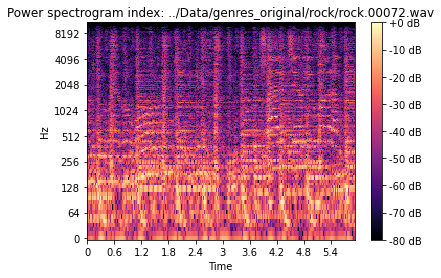

In [67]:
root = './allGenresSuccess1'

save_sample(9999999)

# files = sorted(glob.glob("%s/*" % root))
# print(len(files))
# for file in files:
#     y, sr = librosa.load(file)
#     D = librosa.stft(y)
#     S = np.abs(D)
#     fig, ax = plt.subplots()
#     img = display.specshow(librosa.amplitude_to_db(S,
#                                                         ref=np.max),
#                                 y_axis='log', x_axis='time', ax=ax)
#     ax.set_title(f'Power spectrogram index: {file}')
#     fig.colorbar(img, ax=ax, format="%+2.0f dB")


blurrer = T.GaussianBlur(kernel_size=(5, 9), sigma=(0.6, 0.6))


sample_path = '../Data/genres_original/rock/rock.00072.wav'
# sample_path = './testStuff/990.wav'


y, sr = librosa.load(sample_path)

y = y[:131000]

D = torch.FloatTensor([librosa.stft(y, n_fft=n_fft)])

D = blurrer(D)
D = D[0].numpy()

# D[600:-10] = 0
y_out = librosa.istft(D, length=musicLen)
sf.write("modifyStuff/%d.wav" % 69, y_out, sr)
S = np.abs(D)
fig, ax = plt.subplots()
img = display.specshow(librosa.amplitude_to_db(S,
                                                    ref=np.max),
                            y_axis='log', x_axis='time', ax=ax)
ax.set_title(f'Power spectrogram index: {sample_path}')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

# print(gen_pixel_losses)



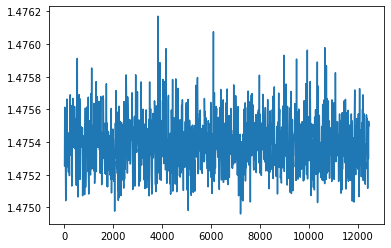

In [54]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=counter, y=gen_adv_losses, mode='lines', name='Gen Adv Loss'))

fig.update_layout(
    width=1000,
    height=500,
    title="Generator Adversarial Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Gen Adversarial Loss (MSELoss)"),
fig.show()

plt.plot(counter, gen_adv_losses) 

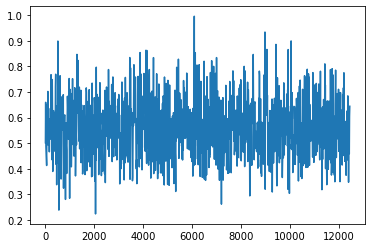

In [56]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=counter, y=gen_pixel_losses, mode='lines', name='Gen Pixel Loss', marker_color='orange'))

fig.update_layout(
    width=1000,
    height=500,
    title="Generator Pixel Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Gen Pixel Loss (L1 Loss)"),
fig.show()

plt.plot(counter, gen_pixel_losses) 

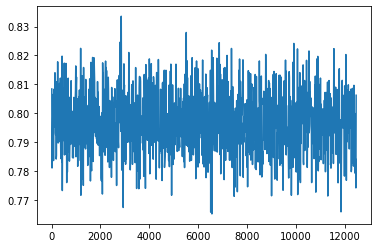

In [57]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=counter, y=disc_losses, mode='lines', name='Discriminator Loss', marker_color='seagreen'))

fig.update_layout(
    width=1000,
    height=500,
    title="Discriminator Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Disc Loss (MSELoss)"),
fig.show()

plt.plot(counter, disc_losses) 

### Work in Progress ...